**Importing the libraries and loading the data**

If imports are returning errors, run `%pip install [missing import]`

In [1]:
# some basic libraries
import pandas as pd
import os
import gdown
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import io

# some libraries useful for text pre-processing and text data exploration
import re, string
# %pip install pyLDAvis

# Import necessary libraries
import gensim
import pyLDAvis
import pyLDAvis.gensim_models
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# some libraries for for model-building and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report

# some libraries for feature extraction from texts
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer #bag of words
from gensim.models import Word2Vec #word embedding


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a1974\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\a1974\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
url = 'https://drive.google.com/file/d/1r5xDdeOsuwUDZy_1GVNf_hS8vxQ7LtEV/view?usp=share_link'

# Extract file ID from the URL
file_id = url.split('/')[-2]

# Construct the download URL
dwn_url = f'https://drive.google.com/uc?id={file_id}'

# Download the file
output = 'complaints.csv'

# Download only if file doesn't already exist
if not os.path.exists(output):
    gdown.download(dwn_url, output, quiet=False)
else:
    print("File already exists. Skipping download.")

# Read the downloaded CSV file into a DataFrame
data = pd.read_csv(output)

# data.head()


File already exists. Skipping download.


In [3]:
# Filters the dataset to only include rows where the 'Company' column is exactly 'CITIBANK, N.A.'
citigroup_data = data[data['Company'] == 'CITIBANK, N.A.']

# Displays the first 5 rows of the filtered DataFrame to preview the data
# citigroup_data.head()

**Pre text processing**

Stemming

In [4]:
def text_stemming(text):
    # Convert the input to string in case it isn't (to avoid errors)
    text = str(text)

    # Initialize the Porter stemmer from NLTK (used to reduce words to their root form)
    stemmer = nltk.porter.PorterStemmer()

    # Split the text into individual words (tokens), stem each token, then join back into a single string
    stemmed = ' '.join([stemmer.stem(token) for token in text.split()])

    # Return the stemmed version of the text
    return stemmed

#End of Mingyang's Edits (7/15/25)

Task

In [5]:
#Begin Stacy's Edits for 7/16/25
def preProcess(s):
    # task: this function iterates through all the words in a string, 
    # removes all X's and slashes (redacted info), then pieces it back into a sentence
    # hint: regular expression to remove all X's: "[0-9]*[X]*[X]+[/]*[0-9]*"
    j = " ".join([re.sub(r'[0-9]*[X]*[X]+[/]*[0-9]*', '', x) for x in s.split()])

    return j

In [6]:
citigroup_data = citigroup_data.dropna(subset=['Consumer complaint narrative'])
# converts the contents of 'Consumer complaint narrative' into string (str)
citigroup_data['Consumer complaint narrative'] = citigroup_data['Consumer complaint narrative'].astype(str)

In [7]:
# creates a new column, 'clean_text' with content from 'Consumer complaint narrative' with every response preprocessed
citigroup_data['clean_text'] = citigroup_data['Consumer complaint narrative'].apply(lambda x: preProcess(x))
# This uses a lambda function, in the format lambda argument: expression, where the expression is executed and returns a value


# citigroup_data

Task

In [8]:
# task: create a new column in citigroup_data called 'stemmed_complaints' 
# and fill it in with the content from 'clean_text'
# but stemmed (with text_stemming applied to it)
citigroup_data['stemmed_complaints'] = citigroup_data['clean_text'].apply(text_stemming)

# show the data
# citigroup_data

# Stop Words

Task

In [9]:
english_stop_words = nltk.corpus.stopwords.words('english')
# some common words might not be in the stop words list. If that ever becomes an issue, you can list a few of them and 
# add them into english_stop_words
def remove_stop_words(text):
    for stopword in english_stop_words:
        word = ' ' + stopword + ' '
        start_date = "" + stopword + "/"
        date = '/' + stopword
        # Task: remove word, start_date, and date everytime they appear in text
        text = text.replace(word, ' ')
        text = text.replace(start_date, '')
        text = text.replace(date, ' ')
    return text

Task

In [10]:
# a new dataframe, info, is created which contains two columns from citigroup_data
info = citigroup_data[['Consumer complaint narrative', 'Company public response']]

# task: create a new column in citigroup_data called 'lowercase_stopworded_complaints',
# which contains content from 'stemmed_complaints' with stop words removed (remove_stop_words)
citigroup_data['lowercase_stopworded_complaints'] = citigroup_data['stemmed_complaints'].apply(remove_stop_words)

# citigroup_data

In [15]:
from gensim.models import LdaModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser

# Specify the column that contains preprocessed complaint text
text_column_name = 'lowercase_stopworded_complaints'

custom_stopwords = {'wa', 'thi', 'ha', 'hi', 'tri', 'becaus', 'ani', 'us', 'citi', 'citibank'}

# Drop nan rows
citigroup_data = citigroup_data.dropna(subset=[text_column_name])

# Convert the entire column to a list of strings (each representing one complaint)
texts = citigroup_data[text_column_name].tolist()

# Step 1: Tokenize your text (you likely already have this part)
tokenized = [
    [token for token in gensim.utils.simple_preprocess(str(doc), deacc=True)
     if token not in custom_stopwords]
    for doc in texts
]

tokenized = [doc for doc in tokenized if isinstance(doc, list) and len(doc) > 0 and doc != ['nan']]

# Step 2: Learn bigram and trigram models
bigram = Phrases(tokenized, min_count=2, threshold=5)
trigram = Phrases(bigram[tokenized], threshold=5)

# Step 3: Create phrasers for faster use
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Step 4: Apply the models to your data
tokenized_bigrams = [bigram_mod[doc] for doc in tokenized]
tokenized_trigrams = [trigram_mod[bigram_mod[doc]] for doc in tokenized]

print("First few tokenized sentences:", tokenized_bigrams[:5])
print("First few tokenized sentences:", tokenized_trigrams[:5])

First few tokenized sentences: [['wire_transfer', 'initi', 'onlin', 'corpor', 'account', 'anoth', 'corpor', 'account', 'name', 'wire_transfer', 'unsuccess', 'ofac', 'cite_reason', 'supervisor', 'wire', 'department', 'avail', 'inform', 'request', 'provided', 'subsequ', 'cancel', 'wire_transfer', 'date', 'fund', 'return', 'reason', 'abl', 'provid', 'ownership', 'detail', 'neither', 'oblig', 'expect', 'know', 'ownership', 'detail', 'valid', 'reason', 'withhold', 'fund', 'fund', 'urgent', 'requir'], ['my_father', 'pass_away', 'inform', 'pass', 'telephon', 'alleg', 'would', 'contact', 'steps', 'never_did', 'contact', 'request', 'fax', 'includ', 'death_certificate', 'live_trust', 'documents', 'letter', 'intent', 'fax', 'abov', 'confirm_receipt', 'end', 'call', 'next_day', 'confirm', 'receiv', 'it', 'letter', 'intent', 'includ', 'instruct', 'close_accounts', 'includ', 'check', 'account', 'save_account', 'sent_letter', 'alleg', 'frozen', 'father', 'check', 'account', 'process', 'withdraw', 'th

In [16]:
from gensim import corpora

dictionary = corpora.Dictionary(tokenized_trigrams)  # or tokenized_bigrams
corpus = [dictionary.doc2bow(text) for text in tokenized_trigrams]

lda = LdaModel(corpus=corpus, num_topics=4, id2word=dictionary, passes=15)

In [17]:
from IPython.display import display, HTML  # Tools to display HTML content directly in a Jupyter Notebook

# Use pyLDAvis to create an interactive topic visualization
# - lda: the trained LDA model
# - corpus: the BoW representation of your documents
# - dictionary: the word-to-ID mapping
# - sort_topics=False keeps the original topic order
#  Prepares the topic model and data for interactive visualization 
lda_display = pyLDAvis.gensim_models.prepare(lda, corpus, dictionary, sort_topics=False)

# Save the interactive visualization as an HTML file locally
pyLDAvis.save_html(lda_display, 'lda.html')

# Display the saved HTML file directly in the notebook
display(HTML('lda.html'))

# Circles: 
# Each circle = a topic
# (Size = how dominant the topic is across all documents)

# Bar charts: 
# Top words in a topic, showing both:
    # Frequency
    # Relevance (more informative words)
        # λ = 1 → Sort words purely by frequency within the topic (i.e., show the most common words).
        # λ = 0 → Sort words by how unique they are to the topic (i.e., most distinctive words).
        # λ = 0.6 (default) → A balanced mix of both.


In [24]:
# Print the topic index and the top keywords for each topic
for idx, topic in lda.print_topics(-1):
    print(f"Topic {idx}: {topic}")

# Manually assign labels to each topic based on the keywords you see
# Replace these labels with your own understanding of what each topic represents
topic_labels = {
    0: "Customer Support / Card Assistance",
    1: "Transaction Disputes / Billing Issues",
    2: "Account Opening / Check Deposit Problems",
    3: "Credit Reporting / Payment Issues"
}

# Example: If you want to access the label for topic 0:
print('\n')
print("Label for topic 0:", topic_labels[0])
print("Label for topic 1:", topic_labels[1])
print("Label for topic 2:", topic_labels[2])
print("Label for topic 3:", topic_labels[3])

Topic 0: 0.026*"call" + 0.017*"told" + 0.016*"card" + 0.012*"would" + 0.011*"get" + 0.010*"account" + 0.010*"ask" + 0.009*"said" + 0.009*"credit_card" + 0.009*"bank"
Topic 1: 0.015*"disput" + 0.009*"request" + 0.008*"provid" + 0.008*"inform" + 0.007*"receiv" + 0.007*"charg" + 0.007*"state" + 0.007*"merchant" + 0.006*"document" + 0.006*"loan"
Topic 2: 0.059*"account" + 0.021*"bank" + 0.014*"open" + 0.014*"receiv" + 0.013*"check" + 0.013*"would" + 0.012*"check_account" + 0.009*"deposit" + 0.009*"offer" + 0.009*"fund"
Topic 3: 0.045*"account" + 0.026*"payment" + 0.013*"report" + 0.013*"maci" + 0.013*"credit" + 0.013*"balanc" + 0.011*"credit_report" + 0.011*"credit_card" + 0.010*"pay" + 0.009*"statement"


Label for topic 0: Customer Support / Card Assistance
Label for topic 1: Transaction Disputes / Billing Issues
Label for topic 2: Account Opening / Check Deposit Problems
Label for topic 3: Credit Reporting / Payment Issues


In [28]:
citigroup_data = citigroup_data.iloc[:-1]
print(len(citigroup_data))
print(len(corpus))

29616
29616


**Importing the libraries and loading the data**

In [ ]:
# This function returns the most dominant topic for each complaint in the corpus
def get_dominant_topic(lda, corpus):
    topic_assignment = []
    for row in lda[corpus]:
        sorted_row = sorted(row, key=lambda x: x[1], reverse=True)  # sort by probability
        topic_assignment.append(sorted_row[0][0])  # get the topic with the highest probability
    return topic_assignment

# Add a new column to the dataframe showing the dominant topic for each complaint
citigroup_data['dominant_topic'] = get_dominant_topic(lda, corpus)

# Map the dominant topic number to your labels
citigroup_data['topic_label'] = citigroup_data['dominant_topic'].map(topic_labels)

# View a sample of complaints with their assigned topic
citigroup_data[['lowercase_stopworded_complaints', 'dominant_topic', 'topic_label']]


,lowercase_stopworded_complaints,dominant_topic,topic_label
55,"a wire transfer {$23000.00} wa initi onlin , c...",2,Account Opening / Check Deposit Problems
75,my father pass away . inform citi hi pass tele...,1,Transaction Disputes / Billing Issues
80,"back 2021, bought . send back twice within 2 m...",0,Customer Support / Card Assistance
154,i platinum card holder macys. gener buy produc...,0,Customer Support / Card Assistance
234,i disput unknown inquir compani credit bureau ...,3,Credit Reporting / Payment Issues
...,...,...,...
3219097,"on 2016, wa induc open citibank citigold check...",1,Transaction Disputes / Billing Issues
3219098,i sent letter ask debt verif place call list. ...,2,Account Opening / Check Deposit Problems
3219099,i spoke repres @ citimortgag advis addit docum...,3,Credit Reporting / Payment Issues
3219100,purchas bra open maci 's card. paid thi follow...,0,Customer Support / Card Assistance


topic_label
Customer Support / Card Assistance          12288
Credit Reporting / Payment Issues            8187
Transaction Disputes / Billing Issues        4701
Account Opening / Check Deposit Problems     4440
Name: count, dtype: int64


<Axes: xlabel='topic_label', ylabel='count'>

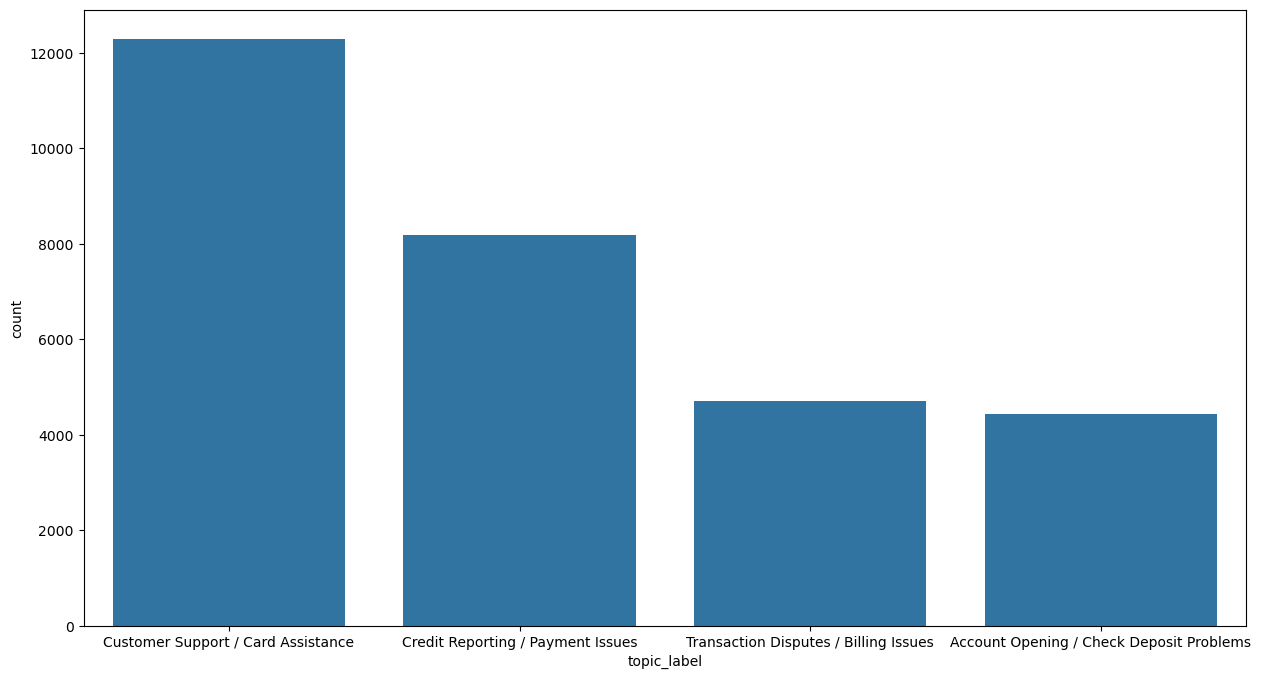

In [39]:
x = citigroup_data['topic_label'].value_counts()

print(x)

plt.figure(figsize=(15, 8))

sns.barplot(x=x.index, y=x)

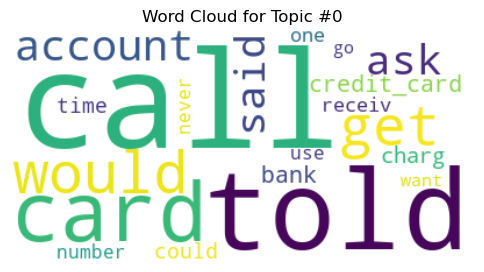

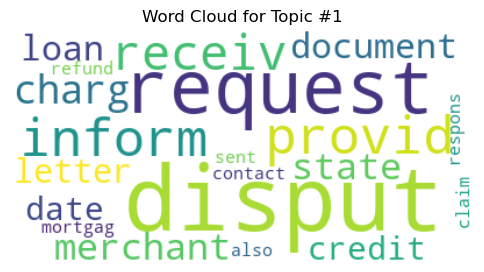

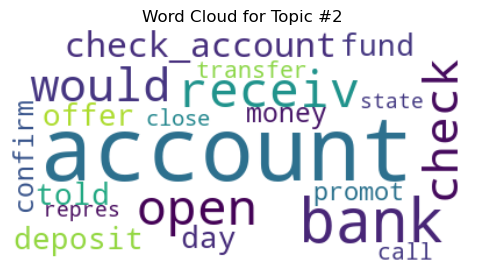

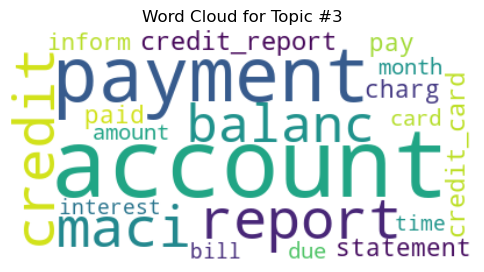

In [31]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Loop through each topic in the model and generate a word cloud
for topic_num in range(lda.num_topics):
    plt.figure(figsize=(6, 4))
    
    # Get top 20 words for this topic with their weights
    topic_words = dict(lda.show_topic(topic_num, 20))
    
    # Generate and display the word cloud
    wordcloud = WordCloud(background_color='white').generate_from_frequencies(topic_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for Topic #{topic_num}")
    plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Use TF-IDF vectorizer to learn term importance across documents
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(citigroup_data['lowercase_stopworded_complaints'])

# Convert the sparse matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate the average TF-IDF score for each word
mean_tfidf = tfidf_df.mean().sort_values(ascending=False)

# Show the top 20 words by average TF-IDF score
print("Top 20 TF-IDF words across all complaints:")
print(mean_tfidf.head(20))

# Optional: Plot a bar chart of the top 20
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.barplot(x=mean_tfidf.head(20).values, y=mean_tfidf.head(20).index)
plt.title("Top 20 Important Words by TF-IDF")
plt.xlabel("Average TF-IDF Score")
plt.ylabel("Word")
plt.show()

Accuracy: 0.39257175014068657

Classification Report:
                                                                               precision    recall  f1-score   support

                                                     Bank account or service       0.00      0.00      0.00       384
                                                 Checking or savings account       0.33      0.35      0.34      1241
                                                               Consumer Loan       0.00      0.00      0.00        29
                                                                 Credit card       0.00      0.00      0.00      1174
                                                 Credit card or prepaid card       0.40      0.90      0.56      3405
                                                            Credit reporting       0.00      0.00      0.00        14
Credit reporting, credit repair services, or other personal consumer reports       0.00      0.00      0.00      1192


Text(0.5, 1.0, 'Confusion Matrix Logistic Regression\n')

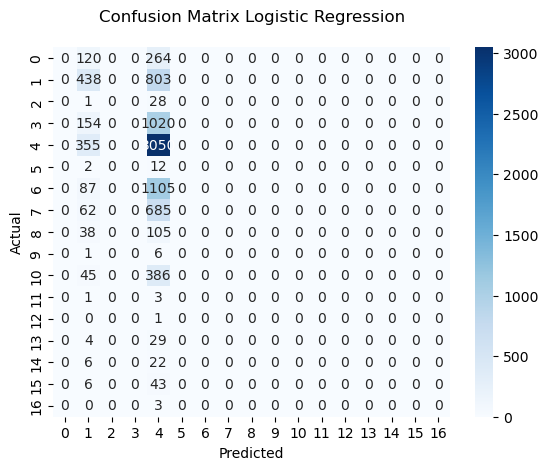

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn import metrics

# Use dominant topic as a feature and 'Product' as the target
X = citigroup_data['dominant_topic']
y = citigroup_data['Product']

# Convert the topic numbers into one-hot encoded vectors
X_onehot = pd.get_dummies(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_onehot, y, test_size=0.3, random_state=42)

# Train a simple logistic regression classifier
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)

# Predict and evaluate performance
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# create a confusion matrix based on the logistic regression model
# plot y_test and y_pred to see where the model is predicting correctly or making mistakes
conf = metrics.confusion_matrix(y_test, y_pred)

# plot labelling
sns.heatmap(conf,annot = True,cmap = "Blues",fmt = 'd')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("Confusion Matrix Logistic Regression\n", size=12)

# optimally, we would want the predicted result to match the actual result - that would mean hotter on the diagonal
# this model is very vaguely on the diagonal
